## Импорт библиотек ##

In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from IPython import display
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (InputLayer, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Flatten)

#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

## Импорт данных ##

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if True:
  ! unzip /content/drive/MyDrive/DCGAN/anime_face.zip -d /content/sample_data

## Генерация данных ##

In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = 32

In [17]:
image_generator = ImageDataGenerator(rescale = 1./255)

In [18]:
# Генерация через flow_from_dataframe
paths = Path('/content/sample_data/images/').glob('*.jpg')
data = pd.DataFrame(data = {'paths' : list(map(str, paths))})

image_generator = image_generator.flow_from_dataframe(dataframe = data, x_col = 'paths', target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                      class_mode = None, batch_size = BATCH_SIZE, shuffle = True)

Found 63565 validated image filenames.


(32, 32, 3)


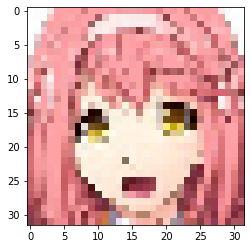

In [19]:
sampel = next(image_generator)

print(sampel[0].shape)
plt.imshow(sampel[0])
plt.show()

## Архитектура DCGAN ##

![alt text](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/raw/master/tensorflow_DCGAN.png)

## Создание модели ##

In [22]:
class DCGAN(tf.keras.Model):

    def __init__(self, latent_dim, image_size, output_path, batch_size, D_h_size = 128, G_h_size = 128, num_channels = 1):
      super().__init__()
      self.latent_dim = latent_dim
      self.multiply = int(np.log2(image_size) - 3)
      self.image_size = image_size
      self.D_h_size = D_h_size
      self.G_h_size = G_h_size
      self.num_channels = num_channels
      self.output_path = output_path
      self.batch_size = batch_size

      self.optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5, beta_2=0.999)
      self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
      self.generator = self._build_generator()
      self.discriminator = self._build_discriminator()
      self.gen_loss_hist = []
      self.disc_loss_hist = []


    def block_conv(self, channels, kernel, stride = 1):
      model = tf.keras.models.Sequential()
      model.add(Conv2D(channels, kernel_size = kernel, padding = 'same', strides = stride, kernel_initializer = init, use_bias=False))
      model.add(BatchNormalization())
      model.add(LeakyReLU())
      return model

    def _build_generator(self):
      model = tf.keras.models.Sequential()      
      model.add(Reshape((1, 1, self.latent_dim), input_shape=(self.latent_dim,)))      
      model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply, kernel_size = 4, strides = 4, kernel_initializer = init, padding = 'same', use_bias=False))
      model.add(BatchNormalization())
      model.add(LeakyReLU())
      for i in range(self.multiply - 1, -1, -1):
        model.add(UpSampling2D())
        model.add(self.block_conv(self.G_h_size * 2**i, 4))
      model.add(UpSampling2D())
      model.add(Conv2D(self.num_channels, kernel_size = 4, padding = 'same', activation = 'tanh', kernel_initializer = init, use_bias=False))
      return model


    def _build_discriminator(self):
      model = tf.keras.models.Sequential()
      model.add(InputLayer(input_shape = (self.image_size, self.image_size, self.num_channels)))
      model.add(self.block_conv(self.D_h_size, 4, 2))
      for i in range(1, self.multiply+1):
        model.add(self.block_conv(self.D_h_size * 2**i, 4, 2))
      model.add(Conv2D(1, kernel_size = 4, kernel_initializer = init, use_bias=False))
      model.add(Flatten())
      return model

    def generator_loss(self, fake_output):
      return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def descrimenator_loss(self, real_output, fake_output):
      real_output = self.cross_entropy(tf.ones_like(real_output), real_output)
      fake_output = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_output + fake_output
      return total_loss

    @tf.function
    def train_step(self, images):
      noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.latent_dim])
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generator_images = self.generator(noise, training = True)
        real_output = self.discriminator(images, training = True)
        fake_output = self.discriminator(generator_images, training = True)
        gen_loss = self.generator_loss(fake_output)
        disc_loss = self.descrimenator_loss(real_output, fake_output)
      gradient_of_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradient_of_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
      self.optimizer.apply_gradients(zip(gradient_of_gen, self.generator.trainable_variables))
      self.optimizer.apply_gradients(zip(gradient_of_disc, self.discriminator.trainable_variables))
      return gen_loss, disc_loss

    def save_result(self, epoch):
      noises = np.random.normal(0, 1, (25, self.latent_dim)).astype(np.float32)
      gen_imgs = self.generator(noises, training = False)
      gen_imgs = 0.5 * gen_imgs + 0.5
      fig, axs = plt.subplots(5, 5, figsize = (7, 7))
      img = 0
      for row in range(5):
        for col in range(5):
          axs[row, col].imshow(gen_imgs[img, :, :, :])
          axs[row, col].axis('off')
          img += 1
      fig.savefig(self.output_path / f'{epoch}.png')
      plt.show()

    def train(self, dataset, num_iters = 2000, show_every = 25):
        start = time.time()
        iters = 0
        for image_batch in dataset:
          print('.', end='')
          gen_loss, disc_loss = self.train_step(image_batch)
          self.disc_loss_hist.append(disc_loss.numpy())
          self.gen_loss_hist.append(gen_loss.numpy()) 
          if iters % show_every == 0:
            display.clear_output(wait=True)
            plt.figure()
            plt.plot(self.disc_loss_hist, label="Discriminator loss")
            plt.plot(self.gen_loss_hist, label="Generator loss")
            plt.legend(loc="best")
            plt.figure()
            self.save_result(f"{iters}")
            self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
            print(f"\n{iters}/{num_iters}")
            print(f'Time elapsed from start {time.time() - start} sec')
          iters += 1
          if iters > num_iters:
            print(f'Finished. Time elapsed from start {time.time() - start} sec')
            return

In [29]:
latent_dim = 100
image_size = IMAGE_SIZE
batch_size = BATCH_SIZE
output_path = Path("/content/drive/MyDrive/DCGAN/GAN_anime_64")
output_path.mkdir(exist_ok=True)
(output_path / "model").mkdir(exist_ok=True)

In [30]:
gan = DCGAN(latent_dim, image_size, output_path, batch_size, num_channels = 3)

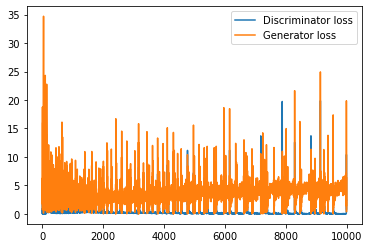

<Figure size 432x288 with 0 Axes>

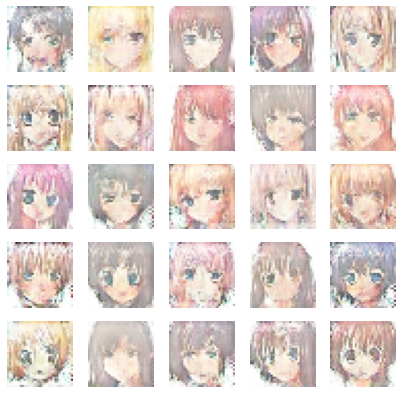


10000/10000
Time elapsed from start 2336.8335180282593 sec
Finished. Time elapsed from start 2336.833549261093 sec


In [31]:
images = list(output_path.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

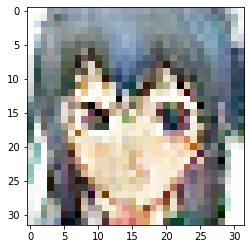

In [47]:
noise = tf.random.normal([tf.cast(1, tf.int32), 100])
result = gan.generator(noise)
plt.imshow(result[0])
plt.show()